In this notebook we will load in fixed pointing for a VISP dataset and then adjust the header table of the dataset with that fixed pointing and then make a new dataset with a new gWCS object.

This requires the `dkist-inventory` package to be installed from pip.

In [41]:
import numpy as np
from scipy.io import readsav

import astropy.units as u
from astropy.coordinates.matrix_utilities import rotation_matrix
from astropy.table import Table

import dkist
from dkist_inventory.asdf_generator import dataset_object_from_filenames
from dkist_inventory.header_parsing import HeaderParser

In [2]:
ds = dkist.load_dataset("/data/dkist/prod/pid_1_123/BKEWK")
ds

This Dataset has 4 pixel and 5 world dimensions

dask.array<reshape, shape=(4, 688, 976, 2555), dtype=float64, chunksize=(1, 1, 976, 2555), chunktype=numpy.ndarray>

Pixel Dim  Axis Name                Data size  Bounds
        0  polarization state               4  None
        1  raster scan step number        688  None
        2  dispersion axis                976  None
        3  spatial along slit            2555  None

World Dim  Axis Name                  Physical Type                   Units
        0  stokes                     phys.polarization.stokes        unknown
        1  time                       time                            s
        2  helioprojective longitude  custom:pos.helioprojective.lon  arcsec
        3  wavelength                 em.wl                           nm
        4  helioprojective latitude   custom:pos.helioprojective.lat  arcsec

Correlation between pixel and world axes:

               Pixel Dim
World Dim    0    1    2    3
        0  yes   no

In [3]:
ori_headers = ds.headers.copy()

Now let's read in the updated position information, and define some other parameters for the updated header.

In [4]:
pointing_info = readsav("visp.to.hmi.heliocentric.alignment.sav")

fitpos_hpc_lon = pointing_info.fitpos_heliocent_ew
fitpos_hpc_lat = pointing_info.fitpos_heliocent_ns
wavepixel = pointing_info.wavepixel

In [5]:
angle = 1.12 * u.deg  # TODO: Check the sign of this rotation and now rotation_matrix works
cdelt_new = {'CDELT1': 0.02976, 'CDELT2': 0.001280, 'CDELT3': 0.0606}
crpix_new = {'CRPIX1': int(2555/2), 'CRPIX2': 0, 'CRPIX3': 0}
crval_new = {'CRVAL1': 0, 'CRVAL2': 0,'CRVAL3': 0}
spatial_pc_new = rotation_matrix(angle)[:2, :2]
# Now insert the spectral axes into the pc matrix
# First insert two zeros as the second row to pad the non-spectral axes
pc_new = np.insert(spatial_pc_new, 1, [0, 0], axis=0)
# then insert the spectral column into the new (3, 2) matrix
pc_new = np.insert(pc_new, 1, [0, 1, 0], axis=1)
pc_keys = {f"PC{i+1}_{j+1}": pc_new[i, j] for i, j in np.ndindex(pc_new.shape)}

Now define a dict of updated header keys which will be applied to all files

In [6]:
global_new_header = {**cdelt_new, **crpix_new, **crval_new, **pc_keys, "CRVAL2": 630.19998}

In [7]:
def update_row(row, new_dict):
    for key, value in new_dict.items():
        row[key] = value
    return row

In [9]:
for header in ds.headers:
    raster_index = header["DINDEX3"] - 1
    new_file_header = {"CRVAL1": fitpos_hpc_lat[raster_index],
                       "CRVAL3": fitpos_hpc_lon[raster_index],
                       "CRPIX2": wavepixel[raster_index]}
    # We update the original table in place
    update_row(header, {**global_new_header, **new_file_header})

We now build a new asdf file from this new set of headers.

This is a little messy at the moment as the dkist-inventory package has really only been developed for internal use so far.

In [31]:
# First we build a HeaderParser object from the updated table
hp = HeaderParser.from_headers(ds.headers)

In [32]:
# Then we add the list of filenames to the HeaderParser
hp.filenames = np.array(ds.files.filenames)

In [36]:
new_ds = dataset_object_from_filenames(hp, inventory=ds.inventory, hdu=1)

Creating tabular temporal axis. ddeltas: [3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.117
 3.1165 3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165
 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117
 3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117
 3.1165 3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165
 3.117  3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117
 3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117
 3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.117
 3.1165 3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165
 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117
 3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117
 3.1165 3.117  3.1165 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165
 3.117  3.1165 3.117  3.117  3.1165 3.117  3.1165 3.117  3.1165 3.117
 3.117  3.1165 3.117  3.1165 3.117  3.1165 3.

Now we must point this new ds back at the directory containing the FITS files

In [39]:
new_ds.files.basepath = ds.files.basepath

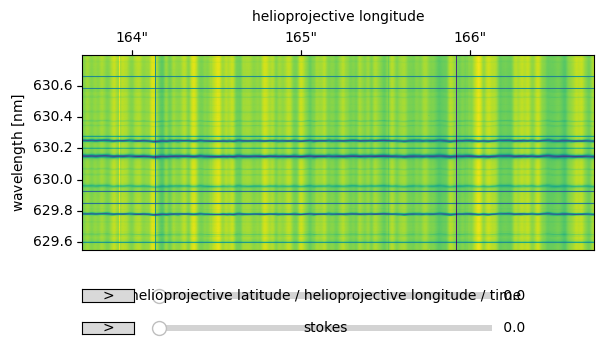

In [40]:
new_ds.plot()

Now save out the new asdf file

In [27]:
import asdf

In [42]:
asdf.AsdfFile(tree={"dataset": new_ds}).write_to("data/VISP/VISP_L1_20221024T185745_BKEWK_corrected.asdf")

In [43]:
new_ds = dkist.load_dataset("data/VISP/VISP_L1_20221024T185745_BKEWK_corrected.asdf")

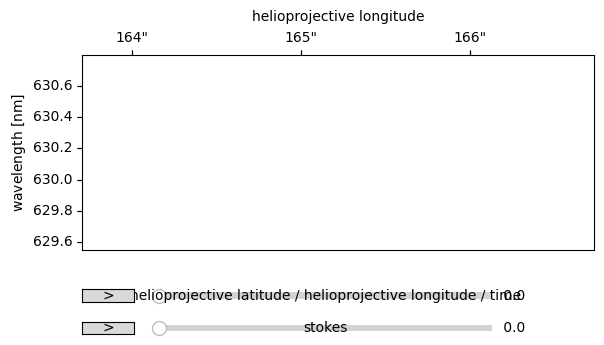

In [44]:
new_ds.plot()